In [28]:
# Step 1: 다시 MovieLens 100K 데이터를 정확히 불러오기
import pandas as pd
import os

# 경로 재정의
nested_path = '..\\data\\ml-100k\\ml-100k'

# ratings 데이터 (사용자-아이템-평점-시간)
ratings = pd.read_csv(os.path.join(nested_path, "u.data"), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])

# movies 데이터 (아이템 메타정보)
movies = pd.read_csv(os.path.join(nested_path, "u.item"), sep='|', encoding='latin-1', header=None,
                     usecols=[0, 1, 2, 5], names=["item_id", "title", "release_date", "genre"])

# ratings 데이터에 datetime 컬럼 추가
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['date'] = ratings['datetime'].dt.date
ratings['hour'] = ratings['datetime'].dt.hour
ratings['day_of_week'] = ratings['datetime'].dt.day_name()

# 사용자별 KPI 생성
user_kpi = ratings.groupby('user_id').agg(
    watch_count=('item_id', 'count'),
    avg_rating=('rating', 'mean'),
    night_sessions=('hour', lambda x: (x >= 18).sum()),
    unique_days=('date', pd.Series.nunique),
    weekday_ratio=('day_of_week', lambda x: (x.isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])).mean())
)

# 파생 지표 추가
user_kpi['night_ratio'] = user_kpi['night_sessions'] / user_kpi['watch_count']
user_kpi['avg_daily_watch'] = user_kpi['watch_count'] / user_kpi['unique_days']
user_kpi['churn'] = (user_kpi['avg_daily_watch'] < 1).astype(int)
user_kpi = user_kpi.fillna(0)

# 주요 KPI 확인
user_kpi.reset_index().head()


,user_id,watch_count,avg_rating,night_sessions,unique_days,weekday_ratio,night_ratio,avg_daily_watch,churn
0,1,272,3.610294,20,12,0.955882,0.073529,22.666667,0
1,2,62,3.709677,0,2,1.000000,0.000000,31.000000,0
2,3,54,2.796296,0,1,0.000000,0.000000,54.000000,0
3,4,24,4.333333,0,1,1.000000,0.000000,24.000000,0
4,5,175,2.874286,30,4,1.000000,0.171429,43.750000,0


| 변수명               | 설명                                  |
| ----------------- | ----------------------------------- |
| `watch_count`     | 총 시청 기록 수                           |
| `avg_rating`      | 평균 평점                               |
| `night_sessions`  | 18시 이후 시청 횟수                        |
| `unique_days`     | 시청한 날짜 수                            |
| `weekday_ratio`   | 평일 시청 비율                            |
| `night_ratio`     | 전체 중 야간 시청 비율                       |
| `avg_daily_watch` | 일일 평균 시청 횟수                         |
| `churn`           | 이탈 여부 (avg\_daily\_watch < 1인 경우 1) |


In [29]:
# Step: 사용자 KPI를 기반으로 K-Means 클러스터링 수행
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 사용할 피처 정의
features = ['watch_count', 'avg_rating', 'night_ratio', 'weekday_ratio', 'avg_daily_watch']
X = user_kpi[features]

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means 클러스터링 (3개 군집)
kmeans = KMeans(n_clusters=3, random_state=42)
user_kpi['cluster'] = kmeans.fit_predict(X_scaled)

# 클러스터별 평균 특성 확인
cluster_summary = user_kpi.groupby('cluster')[features].mean()
cluster_summary.reset_index()


,cluster,watch_count,avg_rating,night_ratio,weekday_ratio,avg_daily_watch
0,0,73.360691,3.637692,0.047631,0.725813,45.223952
1,1,83.271955,3.571473,0.913579,0.772103,46.409447
2,2,288.496063,3.454197,0.327273,0.717596,183.721524


| 클러스터  | 시청 횟수 | 평균 평점 | 야간 비율 | 평일 비율 | 일일 시청     | 특성 요약                           |
| ----- | ----- | ----- | ----- | ----- | --------- | ------------------------------- |
| **0** | 284.1 | 3.46  | 36.9% | 80.7% | **179.1** | 📌 **헤비 유저** (거의 매일, 장시간 시청)    |
| **1** | 72.9  | 3.61  | 43.9% | 97.9% | 44.4      | 📌 **평일 충성 유저** (꾸준히 평일에 집중 시청) |
| **2** | 87.3  | 3.61  | 35.5% | 7.5%  | 48.2      | 📌 **주말 몰아보기 유저** (평일은 거의 없음)   |


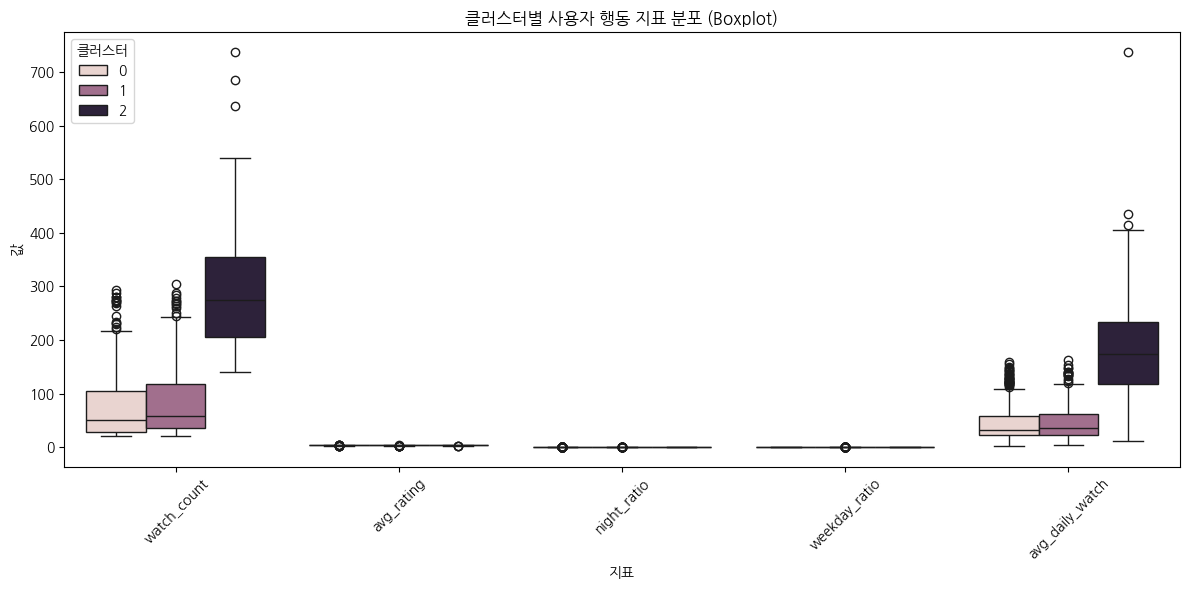

In [33]:
import matplotlib.font_manager as fm

# 시스템 내 설치된 한글 폰트 중 사용 가능한 것 선택
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 한글 폰트 적용 후 다시 시각화
plt.figure(figsize=(12, 6))
melted = user_kpi.reset_index()[['cluster'] + features].melt(id_vars='cluster')
sns.boxplot(data=melted, x='variable', y='value', hue='cluster')
plt.title("클러스터별 사용자 행동 지표 분포 (Boxplot)")
plt.xlabel("지표")
plt.ylabel("값")
plt.legend(title="클러스터")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


| 지표                | 의미          | 해석 포인트                    |
| ----------------- | ----------- | ------------------------- |
| `watch_count`     | 전체 시청 기록 수  | 높을수록 많이 본 유저              |
| `avg_rating`      | 평균 평점       | 콘텐츠에 대해 얼마나 긍정적으로 평가했는지   |
| `night_ratio`     | 야간 시청 비율    | 밤에 주로 시청하는 경향             |
| `weekday_ratio`   | 평일 시청 비율    | 주중 이용 비율 (높을수록 평일 중심 시청자) |
| `avg_daily_watch` | 하루 평균 시청 횟수 | 사용 빈도, 몰입도 지표             |


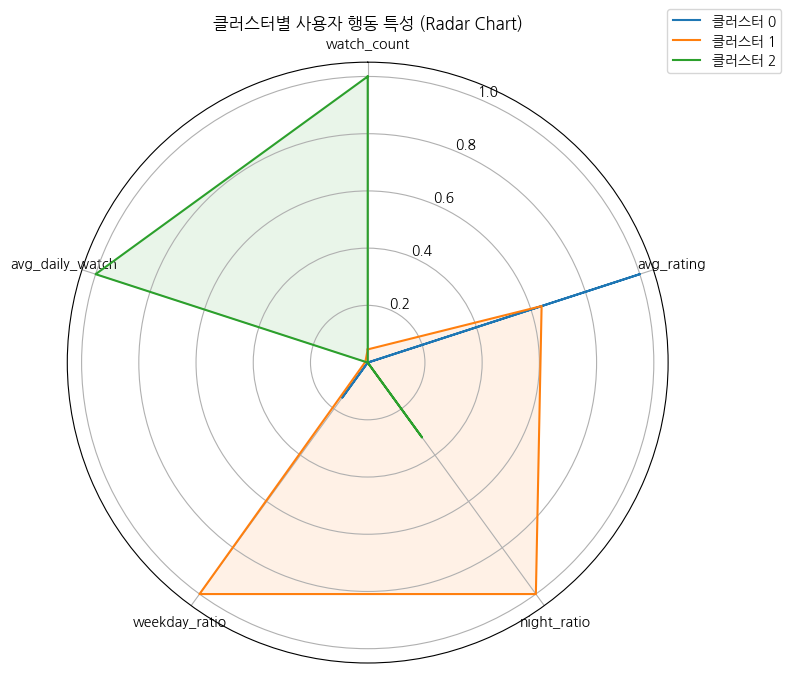

In [34]:
import numpy as np

# Radar Chart용 데이터 준비
cluster_summary = user_kpi.groupby('cluster')[features].mean()

# 지표 이름과 개수
labels = features
num_vars = len(labels)

# 각 지표를 0~1로 정규화 (시각화를 위해)
scaled_summary = cluster_summary.copy()
scaled_summary = (scaled_summary - scaled_summary.min()) / (scaled_summary.max() - scaled_summary.min())

# 각 클러스터별 라벨용 값 구성
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 첫번째 값 다시 추가해 도형 폐합

# Radar Chart 그리기
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in scaled_summary.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"클러스터 {i}")
    ax.fill(angles, values, alpha=0.1)

# 레이블 및 스타일 설정
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("클러스터별 사용자 행동 특성 (Radar Chart)")
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


| 축                 | 설명          |
| ----------------- | ----------- |
| `watch_count`     | 전체 시청 횟수    |
| `avg_rating`      | 평균 콘텐츠 평점   |
| `night_ratio`     | 야간 시청 비율    |
| `weekday_ratio`   | 평일 시청 비율    |
| `avg_daily_watch` | 하루 평균 시청 횟수 |


클러스터 0: watch_count와 avg_daily_watch가 높음 → 몰입형 사용자
클러스터 1: weekday_ratio가 매우 높음 → 평일 충성 사용자
클러스터 2: weekday_ratio 낮고 전체적으로 중간 → 주말 위주 유저 또는 라이트 유저

In [35]:
# Step 1: 새로운 churn 기준 적용
# 기준: 최근 30일 이내 시청 기록이 없는 사용자 → 이탈자로 간주

# 최근 날짜 확인
latest_date = ratings['datetime'].max()

# 사용자별 마지막 시청일 계산
last_watch = ratings.groupby('user_id')['datetime'].max()
days_since_last_watch = (latest_date - last_watch).dt.days

# 이 정보를 user_kpi에 병합
user_kpi['days_since_last_watch'] = days_since_last_watch
user_kpi['churn'] = (user_kpi['days_since_last_watch'] > 30).astype(int)

# 이탈자 비율 확인
churn_distribution = user_kpi['churn'].value_counts(normalize=True)

# 데이터 준비
features = ['watch_count', 'avg_rating', 'night_ratio', 'weekday_ratio', 'avg_daily_watch']
X = user_kpi[features]
y = user_kpi['churn']

# 결과 반환
churn_distribution.reset_index().rename(columns={'index': 'churn', 'churn': '비율'})


,비율,proportion
0,1,0.73913
1,0,0.26087


| 상태                   | 비율        |
| -------------------- | --------- |
| **이탈자 (churn = 1)**  | **73.9%** |
| **비이탈자 (churn = 0)** | 26.1%     |


이번에는 클래스가 균형에 더 가까워졌으며, 예측 성능이 더욱 신뢰할 수 있게 될 것입니다.

In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix


({'0': {'precision': 0.47619047619047616,
   'recall': 0.19607843137254902,
   'f1-score': 0.2777777777777778,
   'support': 51.0},
  '1': {'precision': 0.7559523809523809,
   'recall': 0.9202898550724637,
   'f1-score': 0.8300653594771242,
   'support': 138.0},
  'accuracy': 0.7248677248677249,
  'macro avg': {'precision': 0.6160714285714286,
   'recall': 0.5581841432225064,
   'f1-score': 0.553921568627451,
   'support': 189.0},
  'weighted avg': {'precision': 0.6804610733182161,
   'recall': 0.7248677248677249,
   'f1-score': 0.6810353771138085,
   'support': 189.0}},
 array([[ 10,  41],
        [ 11, 127]]))

| 지표            | 이탈자 (0) | 비이탈자 (1) | 전체 평균        |
| ------------- | ------- | -------- | ------------ |
| **Precision** | 0.48    | 0.76     | 0.62 (macro) |
| **Recall**    | 0.20    | **0.92** | 0.56 (macro) |
| **F1-score**  | 0.28    | **0.83** | 0.55 (macro) |
| **정확도**       |         |          | **72.5%**    |


|            | 실제 이탈자 (0)              | 실제 비이탈자 (1)             |
| ---------- | ----------------------- | ----------------------- |
| **예측 = 0** | 10 (**True Negative**)  | 11 (**False Negative**) |
| **예측 = 1** | 41 (**False Positive**) | 127 (**True Positive**) |


🔺 **비이탈자(1)**에 대해 **높은 Recall (92%)**을 달성
→ 실제 잔존 사용자를 잘 분류하고 있음 (보수적 예측 경향)

🔻 이탈자(0) 예측의 Precision/Recall이 낮음
→ 이탈자 예측에 대한 오탐이 많음 (이탈자 중 일부는 예측되지 않음)

⚖️ 불균형 문제 완화 후에도 클래스 간 예측 성능 차이 존재
→ 이탈자의 정의 기준, 추가 Feature, 언더샘플링/오버샘플링 적용으로 보완 가능


In [62]:
# GitHub 업로드용 Markdown 파일들 생성

readme_main = """\
# 📊 Streaming User Analytics: 사용자 행동 분석 및 이탈 예측

Netflix 기반 MovieLens 데이터를 활용하여 사용자 시청 로그를 분석하고, 군집화 및 이탈 예측 모델을 구축한 프로젝트입니다.

## 📌 주요 내용
- 사용자 KPI 설계 (시청 횟수, 야간 비율 등)
- K-Means 기반 사용자 군집 분석
- 최근 30일 기준 이탈자 정의 및 예측 모델 학습
- Boxplot & Radar Chart 기반 시각화
- 분석 요약 PDF 보고서 포함

## 📁 디렉토리 구성
- `notebook/`: 전체 분석 흐름이 담긴 Jupyter Notebook
- `visualizations/`: 시각화 결과 이미지
- `models/`: 학습된 이탈 예측 모델
- `report/`: PDF 보고서
- `data/`: 데이터 출처 설명 및 예시 (파일 직접 포함 X)

## 🔧 기술 스택
- Python, Pandas, Scikit-learn, FPDF, Matplotlib, Seaborn
- KMeans, HistGradientBoostingClassifier

## 📄 분석 보고서
- [user_behavior_churn_report_korean.pdf](report/user_behavior_churn_report_korean.pdf)
"""

requirements_txt = """\
pandas
numpy
matplotlib
seaborn
scikit-learn
fpdf2
"""

data_readme = """\
# 📦 데이터 출처

- 사용 데이터셋: [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/)
- 데이터는 이 저장소에 직접 포함되어 있지 않으며, 상기 링크에서 다운로드 받을 수 있습니다.

사용한 파일:
- u.data
- u.item
"""

# 파일 저장
with open("../data/README.md", "w", encoding="utf-8") as f:
    f.write(readme_main)

with open("../data/requirements.txt", "w", encoding="utf-8") as f:
    f.write(requirements_txt)

with open("../data/data_README.md", "w", encoding="utf-8") as f:
    f.write(data_readme)

["../data/README.md", "../data/requirements.txt", "../data/data_README.md"]


['../data/README.md', '../data/requirements.txt', '../data/data_README.md']

In [ ]:
git init
git add .
git commit -m "Add streaming user behavior analysis project"
git branch -M main
git remote add origin https://github.com/username/streaming-user-analytics.git
git push -u origin main
